## ABOUT

- deeper custom head
- fewer epochs to avoid overfitting
---
- Best MAE: 2.22
- LB Score: 1.721

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
import tqdm

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.48
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v4'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = 224  # (y, x)
bs = 32
num_workers = 6    # set to available cores

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following hab been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
path = pathlib.Path.home()/'.fastai/data/earthquake'
path.ls()

[PosixPath('/root/.fastai/data/earthquake/sample_submission.csv'),
 PosixPath('/root/.fastai/data/earthquake/test.zip'),
 PosixPath('/root/.fastai/data/earthquake/train.csv.zip'),
 PosixPath('/root/.fastai/data/earthquake/train.csv'),
 PosixPath('/root/.fastai/data/earthquake/saved_models'),
 PosixPath('/root/.fastai/data/earthquake/X_train.csv'),
 PosixPath('/root/.fastai/data/earthquake/y_train.csv'),
 PosixPath('/root/.fastai/data/earthquake/train_images'),
 PosixPath('/root/.fastai/data/earthquake/test_images'),
 PosixPath('/root/.fastai/data/earthquake/submission.csv'),
 PosixPath('/root/.fastai/data/earthquake/test')]

In [7]:
# look at images dir
img_path = path/'train_images'
img_path.ls()[:5]

[PosixPath('/root/.fastai/data/earthquake/train_images/seg_0.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_1.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_2.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_3.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_4.png')]

In [8]:
# look at saved models dir
save_path = path/'saved_models'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
save_path.ls()[:5]

[PosixPath('/root/.fastai/data/earthquake/saved_models/v1-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/earthquake/saved_models/v1-stage-2-1.pth'),
 PosixPath('/root/.fastai/data/earthquake/saved_models/v2-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/earthquake/saved_models/v2-stage-2-1.pth'),
 PosixPath('/root/.fastai/data/earthquake/saved_models/v3-stage-1-1.pth')]

In [9]:
# load segment CSVs
pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [10]:
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164258,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791033,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [11]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


## MODEL

In [12]:
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf

In [13]:
gen_label(img_path/'seg_0.png')

1.4307971859

In [14]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [15]:
fake_label = 0.
src = (ImageList.from_folder(img_path)
        .split_by_rand_pct(valid_pct=0.20)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder('../test_images', label=fake_label))

In [16]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [17]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3079
valid:  769
test:   2624

TOTAL:  6472


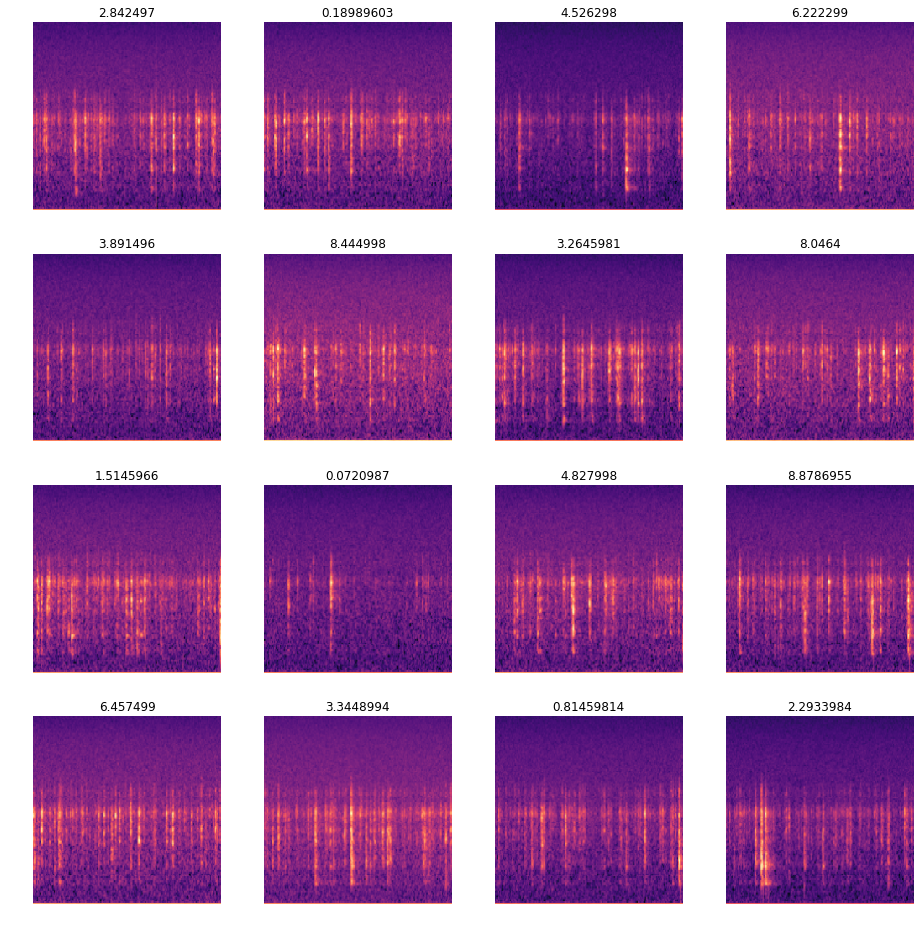

In [18]:
# verify images and labels match up
data.show_batch(4, figsize=(13, 13))

In [21]:
# define metrics
def mse(preds, targs):
    return mean_squared_error(preds.view(-1), targs.view(-1))

def mae(preds, targs):
    return mean_absolute_error(preds.view(-1), targs.view(-1))

In [22]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [23]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7
    elif arch == models.resnet50 and size == 224: return 2048*7*7

In [24]:
# define linear layer that maps final conv layer to output
#head_reg1 = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))
head_reg1 = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

In [41]:
learn = cnn_learner(data, arch, custom_head=head_reg1, loss_func=l1_loss, metrics=[mse, mae])

In [42]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________

## TRAIN

#### Stage 1-1

In [43]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


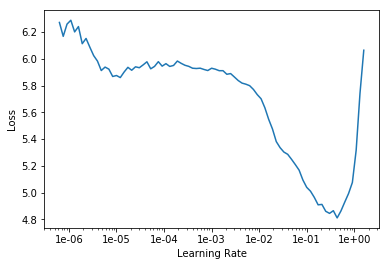

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(4, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,mse,mae,time
0,3.102685,2.374377,9.099158,2.374377,00:13
1,2.410143,2.285870,8.199758,2.285870,00:13
2,2.190976,2.220613,8.232986,2.220613,00:13
3,1.989219,2.224005,8.153760,2.224005,00:13


In [46]:
learn.save(save_path/f'{version}-stage-1-1')

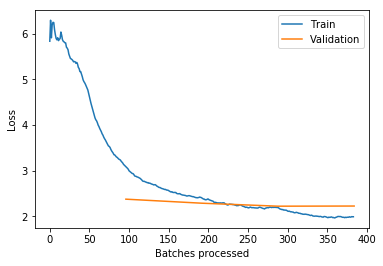

In [47]:
learn.recorder.plot_losses()

#### Stage 2-1

In [52]:
learn.load(save_path/f'{version}-stage-1-1');

In [53]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


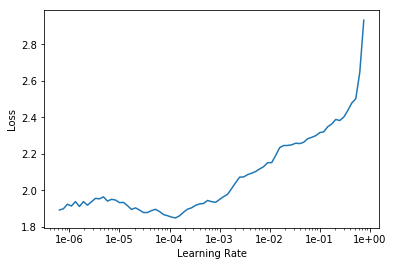

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(4, max_lr=slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,mse,mae,time
0,1.896303,2.229722,8.289568,2.229722,00:18
1,1.840062,2.234795,8.277029,2.234795,00:18
2,1.813114,2.231424,8.193427,2.231423,00:18
3,1.803135,2.229974,8.139583,2.229974,00:18


In [56]:
learn.save(save_path/f'{version}-stage-2-1')

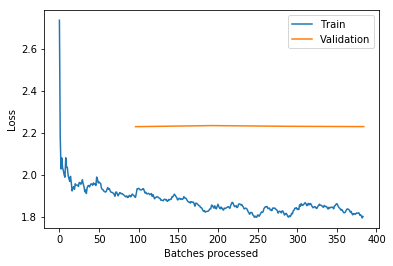

In [57]:
learn.recorder.plot_losses()

## RESULTS

In [58]:
valid_preds, valid_targs = learn.get_preds(ds_type=DatasetType.Valid)

In [61]:
print('min: ', min(valid_preds).item())
print('max: ', max(valid_preds).item())

min:  -2.0823936462402344
max:  11.763749122619629


In [75]:
valid_preds[:5].squeeze()

tensor([9.2593, 4.5663, 3.0149, 8.0430, 8.6934])

In [76]:
valid_targs[:5]

tensor([6.7085, 5.8026, 2.7477, 4.8006, 0.1619])

In [64]:
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [65]:
test_preds

tensor([[3.9655],
        [4.7558],
        [6.3369],
        ...,
        [3.3186],
        [2.6124],
        [8.1394]])

## SUBMISSION

In [77]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [78]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() for i in range(len(test_preds))]

In [79]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.965497016906738
seg_0012b5,4.755786895751953
seg_00184e,6.336901664733887
seg_003339,9.049104690551758
seg_0042cc,4.967848300933838


In [80]:
submission.to_csv(path/'submission.csv')

In [81]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Message"

100%|██████████████████████████████████████| 74.8k/74.8k [00:02<00:00, 26.2kB/s]
Successfully submitted to LANL Earthquake Prediction